In [1]:
### WHAT IS ACTUALLY HAPPENING ON jupyter.nsls2.bnl.gov
#from databroker.v1 import Broker

from databroker import Broker
db = Broker.named('csx')


from csxtools.utils import get_fastccd_images, get_fastccd_flatfield
from csxtools.ipynb import image_stack_to_movie, show_image_stack  # FOUND MOVIE and should be working again

import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import interact
def browse_images(res,title='Frame'):
    N = len(res)
    def view_image(i=0):
        im.set_data(res[i])
        ax.set_title(f'{title} {i}')
        fig.canvas.draw_idle()
    interact(view_image, i=(0, N-1))

/srv/conda/envs/notebook/lib/python3.9/site-packages/tiled/profiles.py:108: UserWarning: Skipping /nsls2/users/abarbour/.config/tiled/profiles/profiles.yml. Failed to parse with error: ScannerError(None, None, 'mapping values are not allowed here', <yaml.error.Mark object at 0x2af9e063b3a0>).
  warnings.warn(
OBJECT CACHE: Will use up to 121_499_065_958 bytes (15% of total physical RAM)


# Using FCCD data at CSX with csxtools and scikit-beam
## Notebooks created by CSX beamline staff
## Trust only the [source](https://github.com/ambarb/csx_primer_notebooks/blob/main/CSX_fccd_data.ipynb) of this notebook
Report issues with this notebook on [github](https://github.com/ambarb/csx_primer_notebooks/issues) (aside from github rendering)

### Notebook applies to:
``` python
import csxtools
print(f'{csxtools.__version__=}')
import skbeam
print(f'{skbeam.__version__=}')

csxtools.__version__='0.2.0'
skbeam.__version__='0.0.24'
```

## Updates / Improvements / Patches 

* **FastCCD is broken (one half does not work)**
    - Use the optional argument of `get_fastccd_flatfield()`
        - `half_interval = True` should be added 
        - type `get_fastccd_flatfield?` if you need more information.
     - This implementation is in `csxtools =>"0.1.18"`
* **Image normalization/processing speeds**
    - Motor scan data (required 4D array) now process 5 - 11 times faster (on par with 3D array data like XPCS)
        - Users with **mesh scans**, in particular, will see **improvements**
        - `get_fastccd_images()` is no longer a generator 
            - this does not break existing code of yours
            - however, you can remove subsequent csxtools functions and use only only numpy to hand the output of `get_fastccd_images()`
            - examples are below
    - This implementation is in `csxtools =>"2.0.0"`

## Now to retreive data
This example is for XPCS like data, but includes some example for other data

### Set up

In [2]:
#### PILOT DATA for test ###
### This data is generated by a static sample pattern in saxs geometery, but Q does not matter for this purpose.  Note that there are some 'problems' using the data sets so this is not perfect for fine analysis - just code testing

### 
scan_no = 126365  ; descript = ' long static test'
scan_no = 126360  ; descript = ' 4 um per s'

bgnd1 = None #db[h.start['scan_id']-1]#None #
bgnd2 = None #db[h.start['scan_id']-2]#None #
bgnd8 = db[126362]

use_flatfield = False

##### FILL IN WHEN YOU GET YOUR FLATFIELD SCAN NUMBERS
#use_flatfield = True
#flat_field_header = db[_some_scan_number]
#tuple_dark_headers = (db[_some_scan_number1],db[_some_scan_number2],db[_some_scan_number3])
 

### Notice that the flatfield correction is not enabled above because
- it doesn't exist for the sample data
- the flatfield correction makes the CCD response uniform over the entire area (correct irregularity in photon sensiting)
- ask beamline for the scan numbers, or record them at the time of your experiment

### After 09-21-2022
- there is a custom `plan_name` for the flatfield (`ct_flatfield`)


### Setup to get images and associated scan data

In [3]:
########### working part, don't touch
h = db[scan_no] # h is for header

tbl=h.table() #get everything but IMAGES from FCCD
tbl_bl = h.table('baseline')

ADUpPH = 30*np.nanmean(tbl_bl.pgm_energy_readback)/930
frametime = h.descriptors[0]['configuration']['fccd']['data']['fccd_cam_acquire_period']

if use_flatfield == False:
    ff = None
else:
    # below is pseudo code. you need to define the headers for this to work (uncomment these lines in the previous cell)
    ff = get_fastccd_flatfield(flat_field_header, (tuple_dark_headers), half_interval=True)

### Normalize images
* single point count (like XPCS)

```python
    images = get_fastccd_images(h, (bgnd8, bgnd2, bgnd1), flat=ff, tag='fccd_image')
    
    ## OPTIONAL STEP IS:
    images = np.squeeze(images)
    
    # NOW images ARE READY FOR XPCS from skbeam library
    
```


* multi-point count (spec "timescan" or any bluesky scan)

```python
    images = get_fastccd_images(header, (bgnd8, bgnd2, bgnd1), flat=None)
```

### Example 

In [4]:
images = get_fastccd_images(h, (bgnd8, bgnd2, bgnd1), flat=ff, tag='fccd_image')
print(f'Before squeeze{images.shape=}')
images = np.squeeze(images)
print(f'After squeeze{images.shape=}')
#images = stack[0]  #THIS IS ONE BIG STACK
pixels_in_ADU = True

Missing dark image for gain setting 2
Missing dark image for gain setting 1


Before squeezeimages.shape=(1, 200, 960, 1000)
After squeezeimages.shape=(200, 960, 1000)


In [5]:
images = images[:] / ADUpPH 
pixels_in_ADU = False

APPROXIMATE ADU per photon:			25.2 ADU
Max number photon in 1 image pixel (0.2575s):	392.6 ph


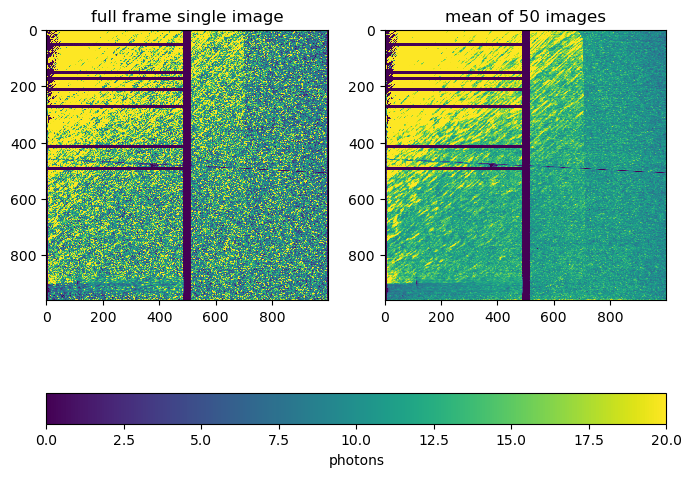

In [6]:
frame_beg = 0
frame_end = 50
floor = 0#np.nanmin(images[1])*2
ceiling = 20#np.nanmax(images[1])

avg_frames = np.nanmean(images[frame_beg:frame_end,:,:],axis=0)

fig, axes = plt.subplots(1,2,figsize=(8,8))
im=axes[0].imshow(images[frame_beg], vmin=floor, vmax=ceiling,
                  cmap='viridis', interpolation='none')
axes[0].set_title('full frame single image')
axes[1].imshow(avg_frames, vmin=floor, vmax=ceiling,
               cmap='viridis', interpolation='none')
axes[1].set_title('mean of {} images'.format(images[frame_beg:frame_end,:,:].shape[0]))

cbar = fig.colorbar(im, ax=axes.ravel().tolist(),orientation="horizontal")
if pixels_in_ADU is True:
    cbar.set_label('ADU')
else:
    cbar.set_label('photons')
maxphoton=np.nanmax(images[frame_beg])
exposuretime=h.descriptors[0]['configuration']['fccd']['data']['fccd_cam_acquire_time']
SUMphoton=np.nansum(np.nansum(images[1,:,:],axis=1),axis=0)

print(f'APPROXIMATE ADU per photon:\t\t\t{ADUpPH:2.1f} ADU')
print(f'Max number photon in 1 image pixel ({exposuretime:.4f}s):\t{maxphoton:2.1f} ph')

### Movie 

In [7]:
print(f'The colorbar units in the movie are {pixels_in_ADU}')

The colorbar units in the movie are False


In [ ]:
image_stack_to_movie(images, vmin=floor, vmax=ceiling)

### Interactive exploration
* currently broken, looking into fix until matplotlib is fixed for `%matplotlib widget`
* `plt.ion()` does work in some cases, but I haven't been successful here

In [ ]:
%matplotlib widget

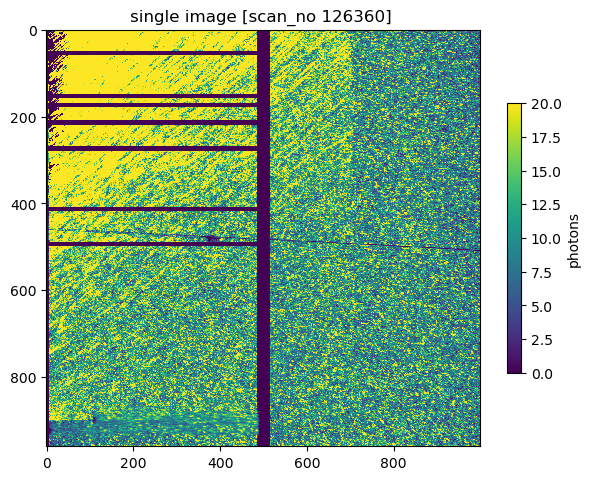

In [8]:
fig, ax = plt.subplots(figsize=(7,7))
ax.set(title='single image [scan_no %s] ' %(h['start']['scan_id']))
im=ax.imshow(images[1],vmin=floor, vmax=ceiling,#np.max(sub_images[1]), 
             cmap='viridis', interpolation='none')
cbar = fig.colorbar(im, ax=ax,shrink=.5, orientation='vertical')
if pixels_in_ADU is True:
    cbar.set_label('ADU')
else:
    cbar.set_label('photons')

### Only works if plot above is interactive

In [ ]:
browse_images(images)

# Essential libraries and functions and quantities for XPCS
```python
import skbeam.core.correlation as corr
import skbeam.core.roi as roi


## CONVERT TO PHOTONS and getting dt for XPCS
ADUpPH = 30*np.nanmean(tbl_bl.pgm_energy_readback)/930 
frametime_dt = h.descriptors[0]['configuration']['fccd']['data']['fccd_cam_acquire_period'] 

## waterfall
roi.kymograph(images,rois) 

## one-time
num_levels = 4 #
num_bufs =  8 #
# these paramters are general, but over and under selection the parameters can mask good things or bad things
# brute force - all times on all images calculated is
#num_levels = 1
#num_bufs = images.shape[0]  # shape = (frames, pixels, pixels)
g2, lag_steps = corr.multi_tau_auto_corr(num_levels, num_bufs, rois, images)

## two-time
num_bufs_tt = images[f_beg:f_end,:,:].shape[0]
num_levels_tt = 1
C2, lag_steps_tt, _state = corr.two_time_corr(rois, images[f_beg:f_end,:,:], images[f_beg:f_end,:,:].shape[0], num_bufs_tt, num_levels_tt)  

```

### Defining images for XPCS
- 3D array that is F-type 
```python
images.shape = (frames, vertical_pixels, horizontal_pixels)
```
- if you are only computing XPCS for 200x200 area, then the code is more performant if you make input the same size
- want to ignore a frame?  make pixel values = np.nan

### Defining roi for XPCS
- 2D array with integer mapping for pixel grouping
    - array must by the same vertical and horzizontal pixels as the images
    - 0 is not computed ever (map pixels to ignore all the time as 0)
    - if pixels in the input XPCS data are always nan, make the associate roi pixel = 0
- Various examples of how to use `roi`:
    - https://github.com/scikit-beam/scikit-beam-examples/blob/master/demos/Generate_ROI_labeled_arrays.ipynb
    - note: some part of pie-slicing is broken with a fix to be pushed soon

